In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import torch
import torch.nn as nn


In [20]:
df = pd.read_csv("data/SensorRec_data_eng.csv")
df.head(5)

,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
0,2023-01-06 10:44:29.466,0.021387,-0.006456,-0.084595,-0.072036,-0.009720,-0.006924,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
1,2023-01-06 10:44:29.958,0.023271,0.100068,0.143770,0.013182,0.004794,0.000399,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
2,2023-01-06 10:44:30.456,0.030368,-0.006946,0.019102,0.000000,-0.001997,0.001198,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.012233,-0.005673,0.002899,0.000266,0.001198,0.001065,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
4,2023-01-06 10:44:31.456,0.017861,0.001417,0.017249,-0.001332,-0.002397,0.000399,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01


In [21]:
df_p1 = df.loc[df['person'] == 'P01', :]
df_p2 = df.loc[df['person'] == 'P02', :]
df_p3 = df.loc[df['person'] == 'P03', :]

dataframe_list = [df_p1, df_p2, df_p3]

## Preprocessing

In [22]:
from maneuver_recognition import preprocessing

x_vars = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed']
y_var = 'maneuverType'
splits = 40
test_size = 0.2
time_steps = 20
stepsize = 4

X_train, y_train, X_test, y_test = [], [], [], []
for df in dataframe_list:
    X_train_df, y_train_df, X_test_df, y_test_df = preprocessing.timeseries_train_test_split(df, x_variables=x_vars,
                y_variable=y_var, splits=splits, test_size=test_size,time_steps=time_steps, step_size=stepsize, scale=True)

    
    X_train.append(X_train_df)
    y_train.append(y_train_df)
    X_test.append(X_test_df)
    y_test.append(y_test_df)
    
X_train, y_train, X_test, y_test = np.vstack(X_train), np.vstack(y_train), np.vstack(X_test), np.vstack(y_test)

X_train

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5745, 20, 7), (1327, 20, 7), (5745, 1), (1327, 1))

In [24]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1]),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1])
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

In [25]:
drop_maneuvers = ['acceleration_lane', 'overtaking', 'deceleration_lane', 'crossing_roundabout', 'crossing_intersection']


X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, drop_maneuvers)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                  'continuous_driving', 0.9)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                  'stationary', 0.8)

In [26]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1],
           text=np.unique(y_train, return_counts=True)[1], textposition='auto'),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1],
           text=np.unique(y_test, return_counts=True)[1], textposition='auto')
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()


In [27]:
encoding = preprocessing.LabelEncoding(y_train, y_test)
y_train, y_test = encoding.transform()

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2012, 20, 7), (2012,), (389, 20, 7), (389,))

In [29]:
X_train, y_train, X_test, y_test = preprocessing.transform_variables(X_train, y_train, X_test, y_test)

In [30]:
print(type(X_train))
print(type(y_train))


<class 'torch.Tensor'>
<class 'torch.Tensor'>


X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

## Modelling

In [31]:
from maneuver_recognition import modelling

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [32]:

number_of_features = X_train.shape[2]
number_of_classes = len(np.unique(y_train))
hidden_size = 24
lstm_layers = 2
lstm_dropout = 0.7

model     = modelling.ManeuverModel(number_of_features, number_of_classes, hidden_size, lstm_layers, lstm_dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

print(model)

ManeuverModel(
  (lstm): LSTM(7, 24, num_layers=2, batch_first=True, dropout=0.7)
  (full_layer1): Linear(in_features=24, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (full_layer2): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=8, bias=True)
)


In [33]:
loss_list, accuracy_list = modelling.train_maneuver_model(model, X_train, y_train, X_test, y_test, epochs=100,
                                         batch_size=128, loss_function=loss_fn, optimizer=optimizer,
                                         device=device)

Epoch 1
-------------------------------
Test Error: Accuracy: 11.6%, Avg loss: 2.079158 

Epoch 2
-------------------------------
Test Error: Accuracy: 18.8%, Avg loss: 2.066536 

Epoch 3
-------------------------------
Test Error: Accuracy: 39.6%, Avg loss: 2.014977 

Epoch 4
-------------------------------
Test Error: Accuracy: 39.3%, Avg loss: 1.882166 

Epoch 5
-------------------------------
Test Error: Accuracy: 39.8%, Avg loss: 1.717399 

Epoch 6
-------------------------------
Test Error: Accuracy: 47.3%, Avg loss: 1.527318 

Epoch 7
-------------------------------
Test Error: Accuracy: 50.4%, Avg loss: 1.378442 

Epoch 8
-------------------------------
Test Error: Accuracy: 50.9%, Avg loss: 1.260875 

Epoch 9
-------------------------------
Test Error: Accuracy: 52.7%, Avg loss: 1.191515 

Epoch 10
-------------------------------
Test Error: Accuracy: 54.0%, Avg loss: 1.140159 

Epoch 11
-------------------------------
Test Error: Accuracy: 54.5%, Avg loss: 1.091946 

Epoch 12

## Evaluation

#### Plot validation accuracy and loss over the training process

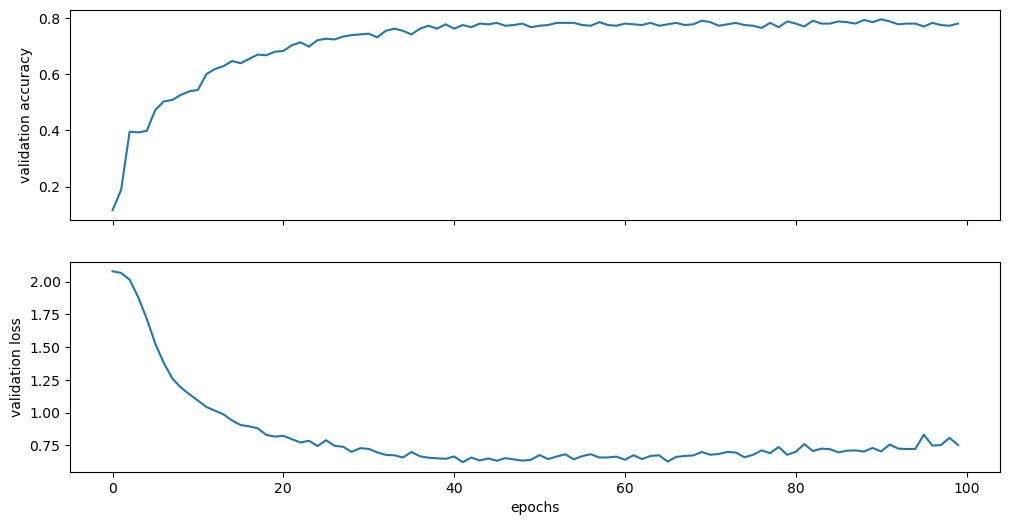

In [34]:
from maneuver_recognition import evaluation
evaluation.plot_training_process(loss_list, accuracy_list)


#### Evaluate model performance via multi class correlation matrix

In [35]:
y_pred = modelling.predict(X_test, model)

# Inverse transform the encoded y
y_test_inverse = encoding.label_encoder.inverse_transform(y_test)
y_pred_inverse = encoding.label_encoder.inverse_transform(y_pred)
classes = encoding.label_encoder.classes_

evaluation.confusion_heatmap(y_test, y_pred, classes, relative=True)